In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Step 1: Data Scraping
def scrape_data(base_url, pages, page_size):
    reviews = []
    for i in range(1, pages + 1):
        print(f"Scraping page {i}")
        url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
        response = requests.get(url)
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')
        for para in parsed_content.find_all("div", {"class": "text_content"}):
            reviews.append(para.get_text().strip())
        print(f"   ---> {len(reviews)} total reviews")

    df = pd.DataFrame(reviews, columns=['reviews'])
    print("Initial Scraped Data:")
    print(df.head())  # Print the first 5 rows of the scraped data
    return df

# Test scraping function
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 3  # Scraping only 3 pages for testing
page_size = 100

df = scrape_data(base_url, pages, page_size)


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Initial Scraped Data:
                                             reviews
0  ✅ Trip Verified |   BA is barely a step above ...
1  Not Verified |  Happy with the flight crew. Ha...
2  ✅ Trip Verified |   Horrible service from boar...
3  Not Verified |  My wife and I are very disappo...
4  Not Verified |  We flew BA between Heathrow an...


In [2]:
import re

# Step 2: Data Cleaning
def clean_data(df):
    # Remove unwanted text like 'Trip Verified'
    remove_text = ['✅ Trip Verified', 'Not Verified |']
    for i in range(len(df['reviews'])):
        for text in remove_text:
            df['reviews'][i] = df['reviews'][i].replace(text, '')

    # Clean special characters
    df['Cleaned Reviews'] = df['reviews'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x))
    print("Data after cleaning special characters:")
    print(df[['reviews', 'Cleaned Reviews']].head())  # Print cleaned data

    return df

# Test data cleaning
df = clean_data(df)


Data after cleaning special characters:
                                             reviews  \
0   |   BA is barely a step above low cost airlin...   
1    Happy with the flight crew. Hadn't been on a...   
2   |   Horrible service from boarding to landing...   
3    My wife and I are very disappointed with fly...   
4    We flew BA between Heathrow and Berlin one w...   

                                     Cleaned Reviews  
0      BA is barely a step above low cost airline...  
1    Happy with the flight crew Hadnt been on a p...  
2    Horrible service from boarding to landing I ...  
3    My wife and I are very disappointed with fly...  
4    We flew BA between Heathrow and Berlin one w...  


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# Step 3: Tokenization and Stopwords Removal
def tokenize_data(df):
    stop_words = set(stopwords.words('english'))
    df['Tokenized'] = df['Cleaned Reviews'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word not in stop_words])
    print("Tokenized and Stopwords Removed:")
    print(df[['Cleaned Reviews', 'Tokenized']].head())  # Print tokenized data
    return df

# Test tokenization
df = tokenize_data(df)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tokenized and Stopwords Removed:
                                     Cleaned Reviews  \
0      BA is barely a step above low cost airline...   
1    Happy with the flight crew Hadnt been on a p...   
2    Horrible service from boarding to landing I ...   
3    My wife and I are very disappointed with fly...   
4    We flew BA between Heathrow and Berlin one w...   

                                           Tokenized  
0  [ba, barely, step, low, cost, airlines, try, d...  
1  [happy, flight, crew, hadnt, plane, years, str...  
2  [horrible, service, boarding, landing, flew, l...  
3  [wife, disappointed, flying, british, airways,...  
4  [flew, ba, heathrow, berlin, one, way, connect...  


In [4]:
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Step 4: POS Tagging and Lemmatization
def pos_lemmatize(df):
    pos_dict = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
    lemmatizer = WordNetLemmatizer()

    def token_stop_pos(text):
        tags = pos_tag(text)
        return [(word, pos_dict.get(tag[0])) for word, tag in tags]

    def lemmatize(text):
        return " ".join([lemmatizer.lemmatize(word, pos=pos) if pos else word for word, pos in text])

    df['POS tagged'] = df['Tokenized'].apply(token_stop_pos)
    print("Data after POS Tagging:")
    print(df[['Tokenized', 'POS tagged']].head())  # Print POS tagged data

    df['Lemmatized'] = df['POS tagged'].apply(lemmatize)
    print("Data after Lemmatization:")
    print(df[['POS tagged', 'Lemmatized']].head())  # Print lemmatized data

    return df

# Test POS tagging and lemmatization
df = pos_lemmatize(df)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Data after POS Tagging:
                                           Tokenized  \
0  [ba, barely, step, low, cost, airlines, try, d...   
1  [happy, flight, crew, hadnt, plane, years, str...   
2  [horrible, service, boarding, landing, flew, l...   
3  [wife, disappointed, flying, british, airways,...   
4  [flew, ba, heathrow, berlin, one, way, connect...   

                                          POS tagged  
0  [(ba, n), (barely, r), (step, v), (low, a), (c...  
1  [(happy, a), (flight, n), (crew, n), (hadnt, a...  
2  [(horrible, a), (service, n), (boarding, v), (...  
3  [(wife, n), (disappointed, v), (flying, v), (b...  
4  [(flew, a), (ba, n), (heathrow, n), (berlin, N...  
Data after Lemmatization:
                                          POS tagged  \
0  [(ba, n), (barely, r), (step, v), (low, a), (c...   
1  [(happy, a), (flight, n), (crew, n), (hadnt, a...   
2  [(horrible, a), (service, n), (boarding, v), (...   
3  [(wife, n), (disappointed, v), (flying, v), (b...   
4  

In [6]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 5: Sentiment Analysis
def sentiment_analysis(df):
    analyzer = SentimentIntensityAnalyzer()

    df['Sentiment Score'] = df['Lemmatized'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
    df['Sentiment'] = df['Sentiment Score'].apply(lambda score: 'Positive' if score >= 0.5 else ('Negative' if score < 0 else 'Neutral'))
    print("Data after Sentiment Analysis:")
    print(df[['Lemmatized', 'Sentiment', 'Sentiment Score']].head())  # Print sentiment analysis data
    return df

# Test sentiment analysis
df = sentiment_analysis(df)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00
Data after Sentiment Analysis:
                                          Lemmatized Sentiment  \
0  ba barely step low cost airline try dime nicke...  Negative   
1  happy flight crew hadnt plane year stress make...  Positive   
2  horrible service board land flew london marrak...  Negative   
3  wife disappoint fly british airway flight canc...  Negative   
4  flew ba heathrow berlin one way connection exp...  Positive   

   Sentiment Score  
0          -0.4445  
1           0.9496  
2          -0.8442  
3          -0.7717  
4           0.9875  


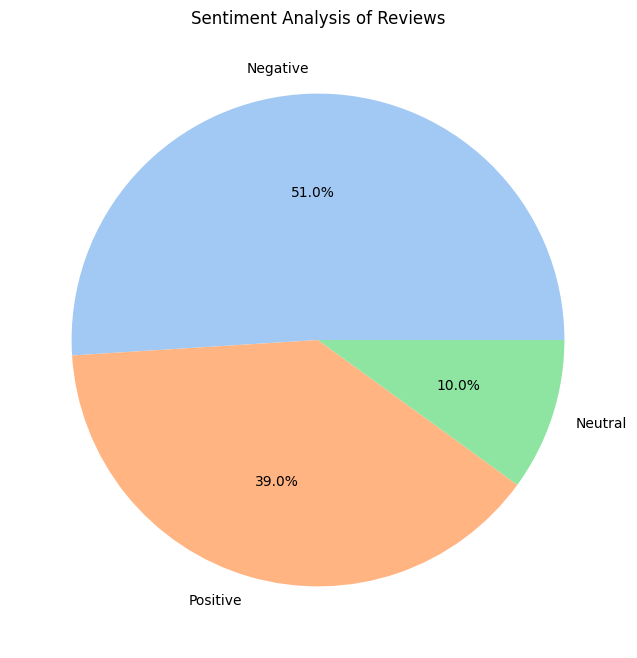

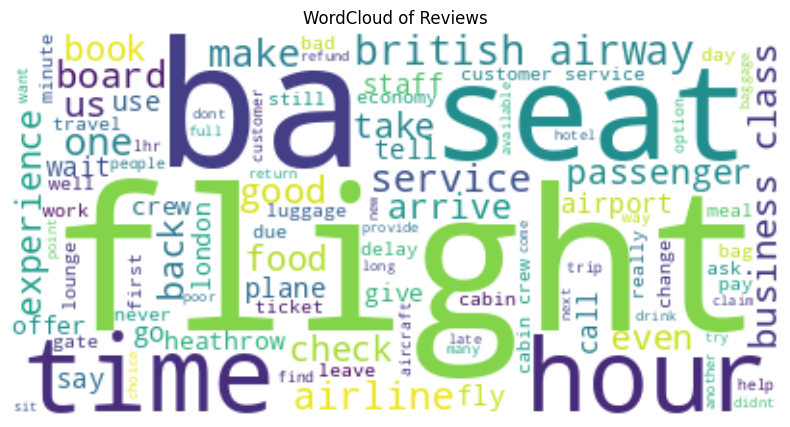

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# Step 6: Data Visualization
def create_visualizations(df):
    # Sentiment Pie Chart
    sentiment_counts = df['Sentiment'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
    plt.title('Sentiment Analysis of Reviews')
    plt.show()

    # WordCloud Visualization
    all_reviews = ' '.join(df['Lemmatized'])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(all_reviews)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud of Reviews')
    plt.show()

# Test visualizations
create_visualizations(df)
